In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as T
from torchvision import models
from torchvision.datasets import ImageFolder

from PIL import Image
import matplotlib.pyplot as plt 

# Data Preprocessing

In [2]:
train_zip = "/content/drive/MyDrive/dogs-vs-cats/train.zip"
test_zip = "/content/drive/MyDrive/dogs-vs-cats/test1.zip"
# Unzip dataset
# This will create two files, "train" and "test1"
import zipfile
with zipfile.ZipFile(train_zip, "r") as z:
    z.extractall()
with zipfile.ZipFile(test_zip, "r") as z:
    z.extractall()

In [3]:
# Make directorys which save data (For ImageFolder)
train_dir = "./train" # get directory to the unzipped file "train"
try:
    if not os.path.exists(f"{train_dir}/cat"): #if the new file "train" doesn't have file "cat"
        os.makedirs(f"{train_dir}/cat")        # made a file "cat"
    if not os.path.exists(f"{train_dir}/dog"):
        os.makedirs(f"{train_dir}/dog")
except OSError:
    print("ERROR : Creating Directory")

In [4]:
import shutil

# Move data according to its name
for file_name in os.listdir(train_dir):
    try:
        cat_or_dog, _, _ = file_name.split(".")
        if cat_or_dog == "cat":
            shutil.move(f"{train_dir}/{file_name}", f"{train_dir}/cat/{file_name}") 
        elif cat_or_dog == "dog":
            shutil.move(f"{train_dir}/{file_name}", f"{train_dir}/dog/{file_name}")
        else:
            print("ERROR : No label")
            break
    except:
        continue
        
print(os.listdir(train_dir))

['cat', 'dog']


In [5]:
# Normalized by channel, calculate the corespponding mean and std
transform_0 = T.Compose([
                T.Resize((256,256)),
                T.ToTensor(),
                
            ])
train_valid_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform = transform_0)
train_valid_dataloader = torch.utils.data.DataLoader(train_valid_dataset, batch_size=128, shuffle=False) # batch =128, faster runtime

means = []
stdevs = []
for X, _ in train_valid_dataloader:
# Dimensions 0,2,3 are respectively the batch, height and width dimensions
# Compute mean values with respect to axis 1. The dimensions of inputs is [batch_size x 3 x image_size x image_size], 
# so we need to make sure we aggregate values per each RGB channel separately.

# We are basically calculating the mean for each RGB layer for each pictrures, and then calcualte the mean across each pictures.
    means.append(X.mean(dim=(0,2,3))) # dim (int or tuple of ints) – the dimension or dimensions to reduce.
    stdevs.append(X.std(dim=(0,2,3)))

mean = torch.stack(means, dim=0).mean(dim=0)
stdev = torch.stack(stdevs, dim=0).mean(dim=0)
print(mean, stdev)

# With mean and std, finally can normalize
train_transform = T.Compose([
                T.Resize((256,256)),
                T.ToTensor(),
                T.Normalize(mean, stdev)
            ])
train_valid_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transform)
print(train_valid_dataset.class_to_idx)
idx_to_class = {v:k for k,v in train_valid_dataset.class_to_idx.items()}
idx_to_class

tensor([0.4883, 0.4551, 0.4170]) tensor([0.2597, 0.2531, 0.2558])
{'cat': 0, 'dog': 1}


{0: 'cat', 1: 'dog'}

In [6]:
# another way of calcualting mean, std for each channel

# transform_0 = T.Compose([
#                 T.Resize((256,256)),
#                 T.ToTensor(),
                
#             ])
# train_valid_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform = transform_0)
# imgs = torch.stack([img_t for img_t, _ in train_valid_dataset], dim=3)
# imgs.shape
# # mean
# imgs.view(3, -1).mean(dim=1)
# # std
# imgs.view(3, -1).std(dim=1)

In [7]:
len(train_valid_dataset)

25000

In [8]:
# torch.zeros([5,3,8,8]) # 3 numbers of 8*8 matrix is small group, there are total 5 such small groups.
test = torch.rand([2,3,2,2])
test

tensor([[[[0.8770, 0.4877],
          [0.5582, 0.9436]],

         [[0.9046, 0.2542],
          [0.0193, 0.1867]],

         [[0.1529, 0.6231],
          [0.7802, 0.3972]]],


        [[[0.1967, 0.2072],
          [0.8960, 0.9414]],

         [[0.1719, 0.8931],
          [0.5556, 0.0633]],

         [[0.4120, 0.1138],
          [0.8280, 0.4210]]]])

In [9]:
# Load Test data
test_dir = "./test1"
# Make directorys which save data (For ImageFolder)
try:
    if not os.path.exists(f"{test_dir}/test"):
        os.makedirs(f"{test_dir}/test")
except OSError:
    print("ERROR : Creating Directory")

for file_name in os.listdir(test_dir):
    try:
        shutil.move(f"{test_dir}/{file_name}", f"{test_dir}/test/{file_name}")
    except:
        continue
os.listdir(test_dir)

['test']

In [10]:
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=train_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
data_size = len(train_valid_dataset)
# Random split dataset
train_dataset, validation_dataset = random_split(train_valid_dataset, [int(0.8 * data_size), int(0.2 * data_size)])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True)

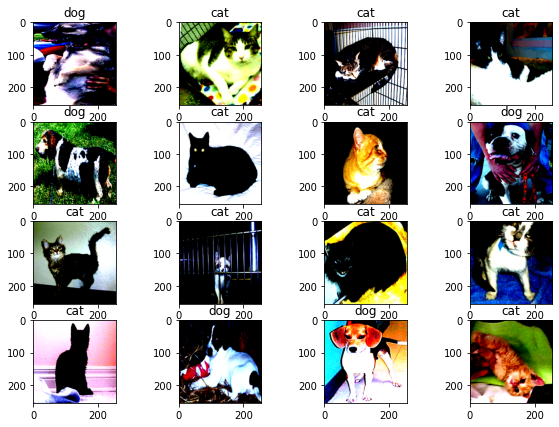

In [12]:
# squeeze funciton -> to remove the dimension with 1
# For example torch.Size([1, 3, 256, 256]) will become torch.Size([3, 256, 256])
# Perumute method -> change dimesions base on the given index order. 
# For example, torch.Size([3, 256, 256]).permute(1, 2, 0)) will become torch.Size([256, 256, 3])

# Display one batch of picturees (16)
fig = plt.figure(figsize=(10, 7))
for value in train_dataloader:
    data, label = value
    # print('Before:', data.shape)
    for i in range(len(label)):
      # print(f"This is ... {idx_to_class[int(label[i].item())]}")
      fig.add_subplot(4,4,i+1)
      data_for_graph = torch.squeeze(data[i]).permute(1, 2, 0)
      plt.imshow(data_for_graph)
      plt.title(idx_to_class[int(label[i].item())])
      # print('After transforming:', data_for_graph.shape)
    break                      

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Base Line Model: Three Layer CNN - 65% Accuracy


In [14]:
def flatten(x):
  N = x.shape[0]
  return x.view(N,-1)

# Base line 
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, channel_3, num_classes):
        super().__init__()
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.cv1 = nn.Conv2d(in_channel, channel_1, 5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(channel_1)
        self.cv2 = nn.Conv2d(channel_1, channel_2, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(channel_2)
        self.cv3 = nn.Conv2d(channel_2, channel_3, 3, padding=0)
        self.conv3_bn = nn.BatchNorm2d(channel_3)
        self.fc = nn.Linear(channel_3*254*254, num_classes)

        self.conv_w1 = nn.init.xavier_normal_(self.cv1.weight)
        self.conv_b1 = self.cv1.bias.data.fill_(0.01)

        self.conv_w2 = nn.init.xavier_normal_(self.cv2.weight)
        self.conv_b2 = self.cv2.bias.data.fill_(0.01)

        self.conv_w3 = nn.init.xavier_normal_(self.cv3.weight)
        self.conv_b3 = self.cv3.bias.data.fill_(0.01)

        self.fc_w = nn.init.xavier_normal_(self.fc.weight)
        self.fc_b = self.fc.bias.data.fill_(0.01)

    def forward(self,x):
        scores=None
        conv_w1 = self.conv_w1
        conv_b1 = self.conv_b1.cuda()
        conv_w2 = self.conv_w2
        conv_b2 = self.conv_b2.cuda()
        conv_w3 = self.conv_w3
        conv_b3 = self.conv_b3.cuda()
        fc_w = self.fc_w.transpose(1,0)
        fc_b = self.fc_b.cuda()

        out = F.conv2d(x, conv_w1, conv_b1, padding=2)
        out = F.relu(self.conv1_bn(out))
        out = F.conv2d(out, conv_w2, conv_b2, padding=1)
        out = F.relu(self.conv2_bn(out))
        out = F.conv2d(out, conv_w3, conv_b3, padding=0)
        out = F.relu(self.conv3_bn(out))
        out = flatten(out)
        scores = out.mm(fc_w) + fc_b

        return scores

In [15]:
def train(loader_data, model, loss_fn, optimizer):
    model = model.to(device=device)
    for batch, (x,y) in enumerate(loader_data):
        model.train()
        x = x.to(device=device)
        y = y.to(device=device)

        scores = model(x)
        loss = loss_fn(scores, y)

        optimizer.zero_grad()

        loss.backward() #backward pass    

        optimizer.step() # update parameters


        if batch % 500 ==0:
          print(f'Iteration {batch}, loss = {loss.item()}')
            
def validation(loader_data, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader_data:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1) # This return the max values, and corresponded index
            num_correct += (preds == y).sum()
            num_samples += preds.size(0) # get the size of 1
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [16]:
# Try baseline
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
model = ThreeLayerConvNet(3, 12, 8, 6, 2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(validation_dataloader, model)
    

Epoch 1
---------------------
Iteration 0, loss = 0.7184569239616394
Iteration 500, loss = 5.1099700927734375
Iteration 1000, loss = 0.7211571335792542
Got 3326 / 5000 correct (66.52)
Epoch 2
---------------------
Iteration 0, loss = 0.4282051622867584
Iteration 500, loss = 0.5556512475013733
Iteration 1000, loss = 0.2843010723590851
Got 3382 / 5000 correct (67.64)
Epoch 3
---------------------
Iteration 0, loss = 0.17550885677337646
Iteration 500, loss = 0.14250004291534424
Iteration 1000, loss = 0.242427259683609
Got 3396 / 5000 correct (67.92)


# Transfer Learing Model: Resnet18 

## Feature Extraction :
## Freeze pre-trained paramaters of Resnet18 except Fully connected Layer - 95% Accuracy

In [17]:
def get_restnet18():
  resnet = models.resnet18(pretrained=True,progress=True)
  # Add FC output layer
  num_ftrs = resnet.fc.in_features #512
  num_classes = 2
  resnet.fc = nn.Linear(num_ftrs, num_classes)
  torch.nn.init.xavier_uniform_(resnet.fc.weight)
  return resnet

In [18]:
# Transfer learning (Freeze paramaters for resent18)

# Get the pretrained resent_18
resnet18_pretrained_freeze = get_restnet18()

# Freeze all the network except final layer
for name, param in resnet18_pretrained_freeze.named_parameters():
    if 'fc' not in str(name):
      param.requires_grad = False

# Check requires_grad
# for name, param in resnet18_pretrained_freeze.named_parameters():
#   print(name, param.requires_grad)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 3e-5
model = resnet18_pretrained_freeze.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(validation_dataloader, model)

Epoch 1
---------------------
Iteration 0, loss = 1.3044612407684326
Iteration 500, loss = 0.5806037187576294
Iteration 1000, loss = 0.2730770409107208
Got 4460 / 5000 correct (89.20)
Epoch 2
---------------------
Iteration 0, loss = 0.15382203459739685
Iteration 500, loss = 0.12320470064878464
Iteration 1000, loss = 0.21324776113033295
Got 4701 / 5000 correct (94.02)
Epoch 3
---------------------
Iteration 0, loss = 0.12373539060354233
Iteration 500, loss = 0.07144887745380402
Iteration 1000, loss = 0.31182217597961426
Got 4804 / 5000 correct (96.08)


## Fine Tuning :
## Lower learning rate for Resnet paramaters - 99% Accuracy

In [20]:
# Transfer learning (lower learning rate for resnet paramaters)
resnet18_pretrained = get_restnet18()


lr, weight_decay = 1e-5, 5e-4
model = resnet18_pretrained.to(device)
# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in resnet18_pretrained.named_parameters() if 'fc' not in str(name)]
# set pretrained paramater learning rate smaller than fc paramater learning rate.
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': resnet18_pretrained.fc.parameters(), 'lr': lr*10}], lr=lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(validation_dataloader, model)

Epoch 1
---------------------
Iteration 0, loss = 0.941051185131073
Iteration 500, loss = 0.6349369287490845
Iteration 1000, loss = 0.13799215853214264
Got 4944 / 5000 correct (98.88)
Epoch 2
---------------------
Iteration 0, loss = 0.12928806245326996
Iteration 500, loss = 0.03384482488036156
Iteration 1000, loss = 0.017877215519547462
Got 4947 / 5000 correct (98.94)
Epoch 3
---------------------
Iteration 0, loss = 0.0025742757134139538
Iteration 500, loss = 0.0003888308710884303
Iteration 1000, loss = 0.007748205214738846
Got 4943 / 5000 correct (98.86)


Since ResNet18 with fine tuning has a higher accuracy (99%) then ResNet18 with Feature Extraction(96%). We decide to use ResNet18 with fine tuning. 

## Retrain the best model on the full dataset

In [21]:
#Full Trainig (train+valid as training dataset)
train_valid_dataloader = DataLoader(train_valid_dataset, batch_size=16, shuffle=True)

resnet18_pretrained = get_restnet18()

lr, weight_decay = 1e-5, 5e-4
model = resnet18_pretrained.to(device)
# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in resnet18_pretrained.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': resnet18_pretrained.fc.parameters(), 'lr': lr*10}], lr=lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------")
    train(train_valid_dataloader, model, loss_fn, optimizer)


Epoch 1
---------------------
Iteration 0, loss = 1.160000205039978
Iteration 500, loss = 0.031032681465148926
Iteration 1000, loss = 0.005185628309845924
Iteration 1500, loss = 0.04698221758008003
Epoch 2
---------------------
Iteration 0, loss = 0.07701142132282257
Iteration 500, loss = 0.02873316965997219
Iteration 1000, loss = 0.008376507088541985
Iteration 1500, loss = 0.05135379731655121
Epoch 3
---------------------
Iteration 0, loss = 0.004206146113574505
Iteration 500, loss = 0.00039040326373651624
Iteration 1000, loss = 0.024637935683131218
Iteration 1500, loss = 0.11502473056316376
Epoch 4
---------------------
Iteration 0, loss = 0.0014287896919995546
Iteration 500, loss = 0.0011625156039372087
Iteration 1000, loss = 0.0003649740247055888
Iteration 1500, loss = 0.00025400944286957383
Epoch 5
---------------------
Iteration 0, loss = 0.00016174859774764627
Iteration 500, loss = 7.148172880988568e-05
Iteration 1000, loss = 0.00013249623589217663
Iteration 1500, loss = 0.00477

# Predit on testset and ouput csv file

In [22]:
# Since our batch size =16, if we use append, we will have a list of lists
# Therefore, we use extend here. 

def test(loader_data, model, list_):
  model = model.to(device=device)
  model.eval()
  for X,_ in loader_data:
    X = X.to(device)
    scores = model(X.cuda())
    # extend function: Iterates over its argument and adding each element to the list and extending the list. 
    list_.extend(scores.argmax(dim=1).type(torch.int32).cpu().numpy()) 

In [23]:
list_ = []
test(test_dataloader, model, list_)

In [24]:
list_int = [int(i) for i in list_]

In [25]:
sumbit = pd.read_csv("/content/drive/MyDrive/dogs-vs-cats/sampleSubmission.csv")
i = sumbit.id
output = pd.DataFrame()
output['id'] = i
output['label'] = list_
output

,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
12495,12496,0
12496,12497,1
12497,12498,1
12498,12499,0


In [26]:
# export to csv and ready to submit!
output.to_csv('my_submission.csv', index=False)